## 1 Compare Hand-coded vs. NN policy

### 1.1 Hand-coded

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


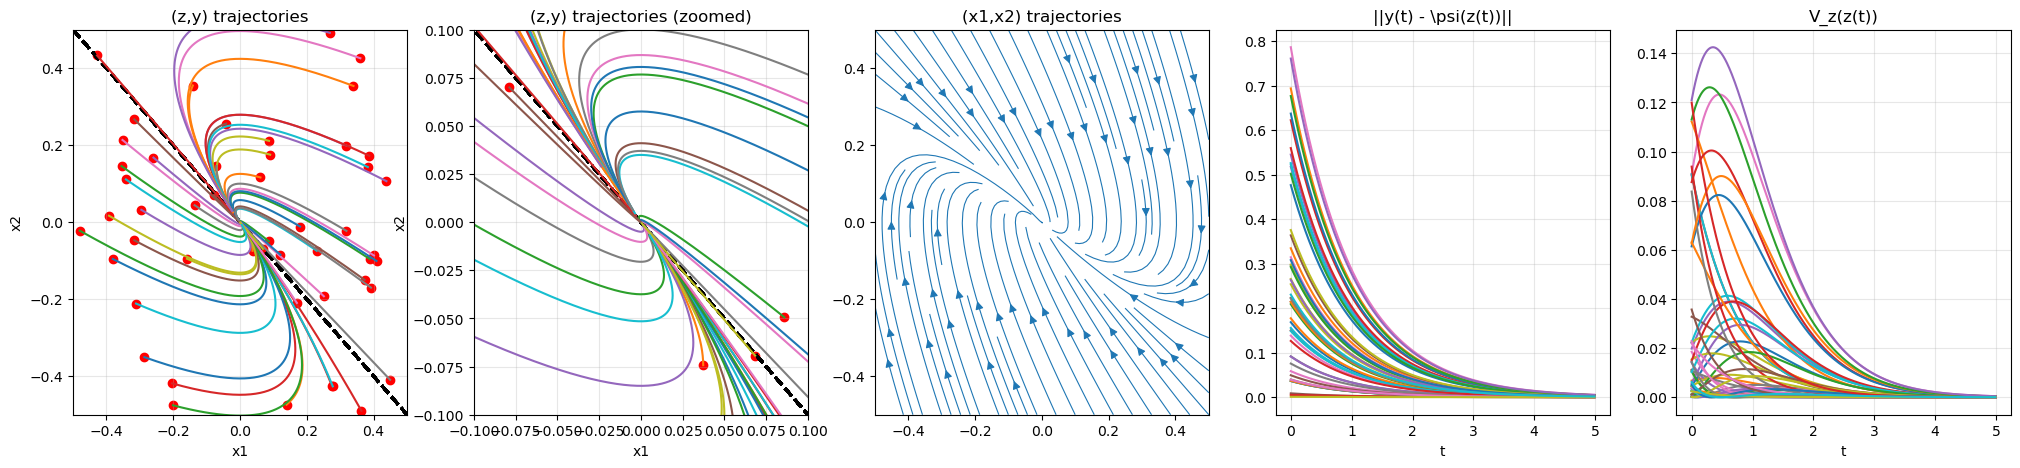

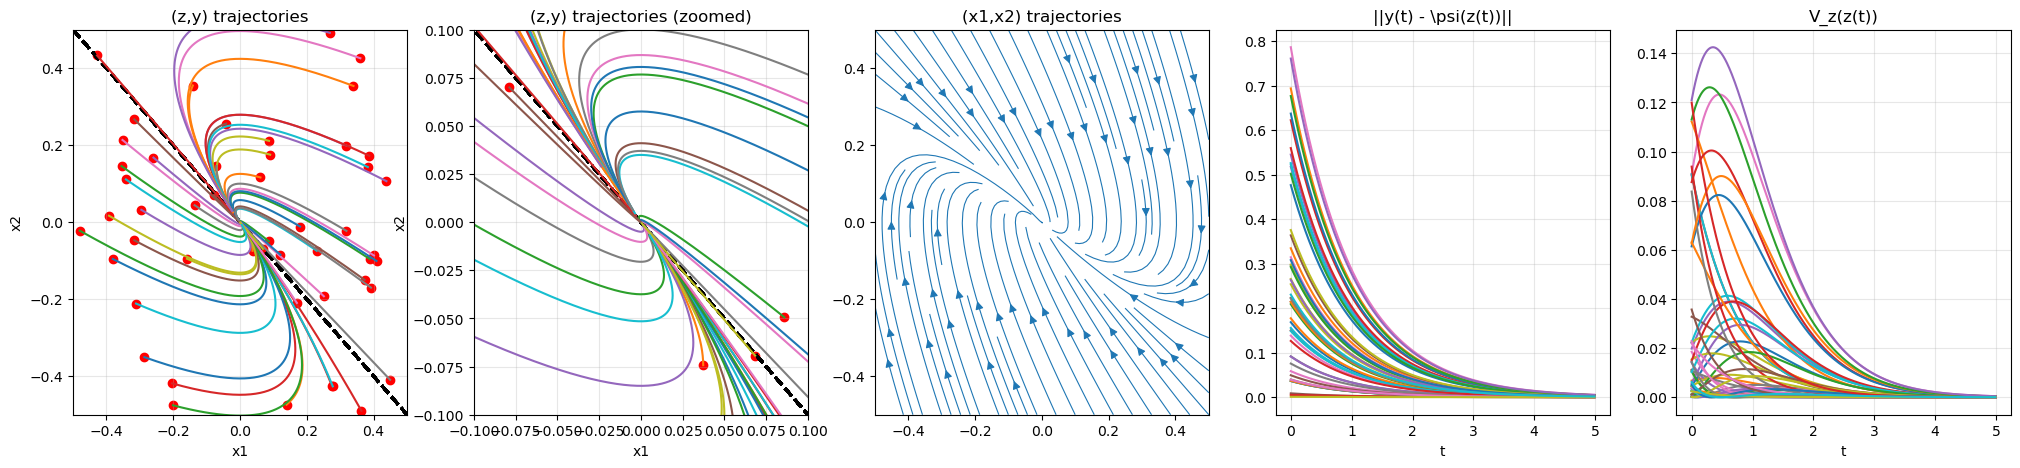

In [ ]:
%load_ext autoreload
%autoreload 2

import jax
from functools import partial

import sys, ipynbname
from os.path import dirname
sys.path.append(dirname(dirname(ipynbname.path())))
from train import *
from rom import *



box_width = 0.5

cfg_rom = CfgDIROM()
cfg_rollout = CfgRollout()
rng = jax.random.PRNGKey(42)

rom = DoubleIntegratorROM(cfg_rom=cfg_rom)
ts = jnp.arange(cfg_rollout.t0, cfg_rollout.t1 + cfg_rollout.dt, cfg_rollout.dt)
x0s = jax.random.uniform(rng, (50, 2), minval=-box_width, maxval=box_width)

integrator = Integrator(
    solver=partial(dfx.diffeqsolve, solver=dfx.Tsit5()),
    ts=ts,
)

rom = DoubleIntegratorROM(cfg_rom=cfg_rom)

ret = integrator.apply(x0s, rom)
aux_ret = integrator.post_apply(ret, rom)

_ = make_traj_plots(rom, ret, aux_ret, box_width=box_width)

### 1.2 NN-based, hardcoded params

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(1,) (50, 1)


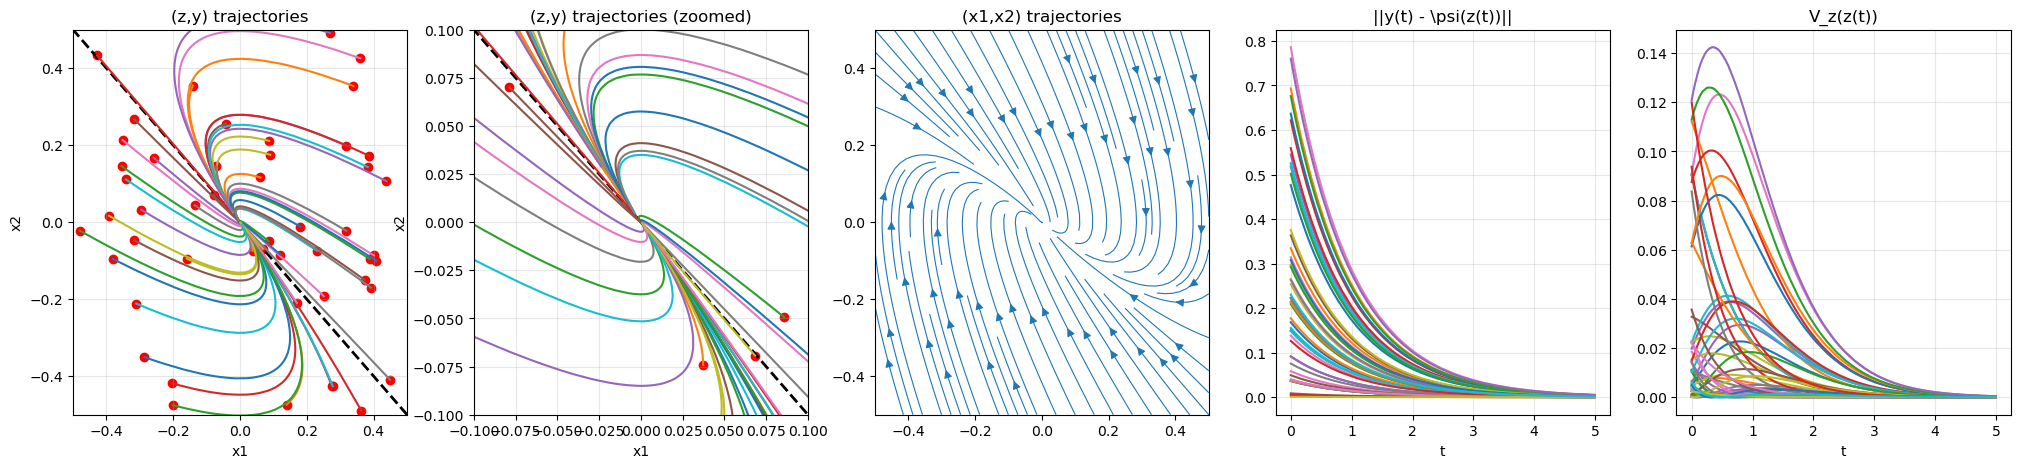

In [ ]:
%load_ext autoreload
%autoreload 2

import jax, flax

import sys, ipynbname
from os.path import dirname
sys.path.append(dirname(dirname(ipynbname.path())))
from train import *
from rom import *



box_width = 0.5

cfg_rom = CfgDIROM()
cfg_rollout = CfgRollout()
rng = jax.random.PRNGKey(42)

params = flax.core.FrozenDict({}) # place holder for NN parameters
ts = jnp.arange(cfg_rollout.t0, cfg_rollout.t1 + cfg_rollout.dt, cfg_rollout.dt)
x0s = jax.random.uniform(rng, (50, 2), minval=-box_width, maxval=box_width)

rom_expert = DoubleIntegratorROM(cfg_rom=cfg_rom)
rom_nn = NNDoubleIntegratorROM(cfg_rom=cfg_rom)
rom_nn.set_nn_params(rom_nn.default_nn_params)

integrator = Integrator(solver=partial(dfx.diffeqsolve, solver=dfx.Tsit5()), ts=ts)

ret1 = rom.policy_v(1.0, 1.0)
ret2 = jax.vmap(rom.policy_v, in_axes=(0, 0))(
    jnp.ones((50,)),
    jnp.ones((50,))
)

print(ret1.shape, ret2.shape)

int_out_nn = integrator.apply(x0s, rom_nn)
int_out_expert = integrator.apply(x0s, rom_expert)
aux_out_nn = integrator.post_apply(int_out_nn, rom_nn)
aux_out_expert = integrator.post_apply(int_out_expert, rom_expert)
loss_out = integrator.compute_loss(int_out_nn, int_out_expert, rom_nn, CfgLoss())
_ = make_traj_plots(rom_nn, int_out_nn, aux_out_nn, box_width=box_width)

    

## 2. Actually Learn NN Policy

Before training:
{'nn_decoder': {'bias': None,
                'kernel': Array([[-1.5153334 , -1.3828858 ],
       [ 0.15761374, -0.2707644 ]], dtype=float32)},
 'nn_encoder': {'bias': None,
                'kernel': Array([[ 0.75672996, -0.6857006 ],
       [-0.5688339 , -0.8757607 ]], dtype=float32)},
 'nn_fy': {'bias': None, 'kernel': Array([[1.3595891]], dtype=float32)},
 'nn_fz': {'bias': None, 'kernel': Array([[0.48590264],
       [0.24484356]], dtype=float32)},
 'nn_gy': {'bias': Array([0.], dtype=float32), 'kernel': Array([[-0.6707529]], dtype=float32)},
 'nn_psi': {'bias': None, 'kernel': Array([[1.2307235]], dtype=float32)}}


100%|██████████| 10/10 [00:46<00:00,  4.66s/it, loss=2.31e-01, lr=5.00e-02]



Params after training:
{'nn_decoder': {'bias': None,
                'kernel': Array([[-0.5942152 , -0.742549  ],
       [-1.0127019 , -0.01504134]], dtype=float32)},
 'nn_encoder': {'bias': None,
                'kernel': Array([[-0.04798745, -0.89731926],
       [-1.0013814 ,  0.14180647]], dtype=float32)},
 'nn_fy': {'bias': None, 'kernel': Array([[0.07241282]], dtype=float32)},
 'nn_fz': {'bias': None, 'kernel': Array([[0.81339014],
       [0.01154388]], dtype=float32)},
 'nn_gy': {'bias': Array([-1.1024209], dtype=float32), 'kernel': Array([[-0.05245165]], dtype=float32)},
 'nn_psi': {'bias': None, 'kernel': Array([[1.6516852]], dtype=float32)}}


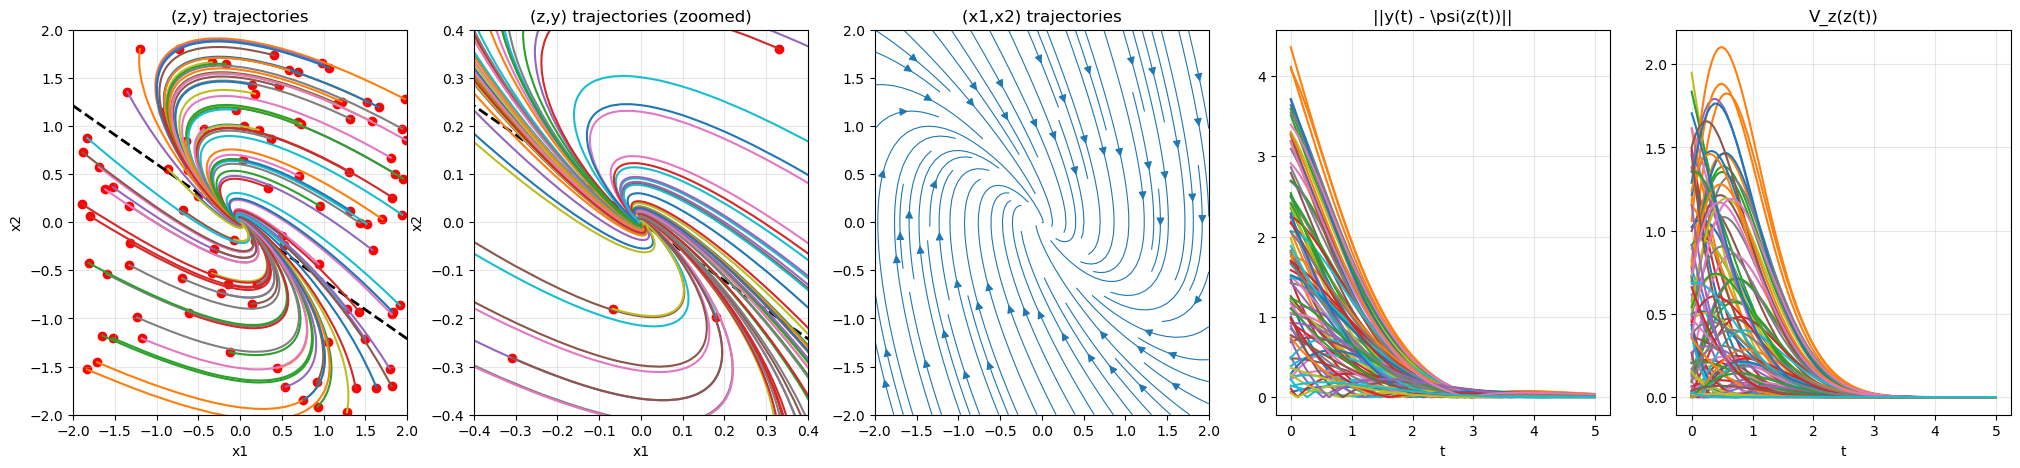

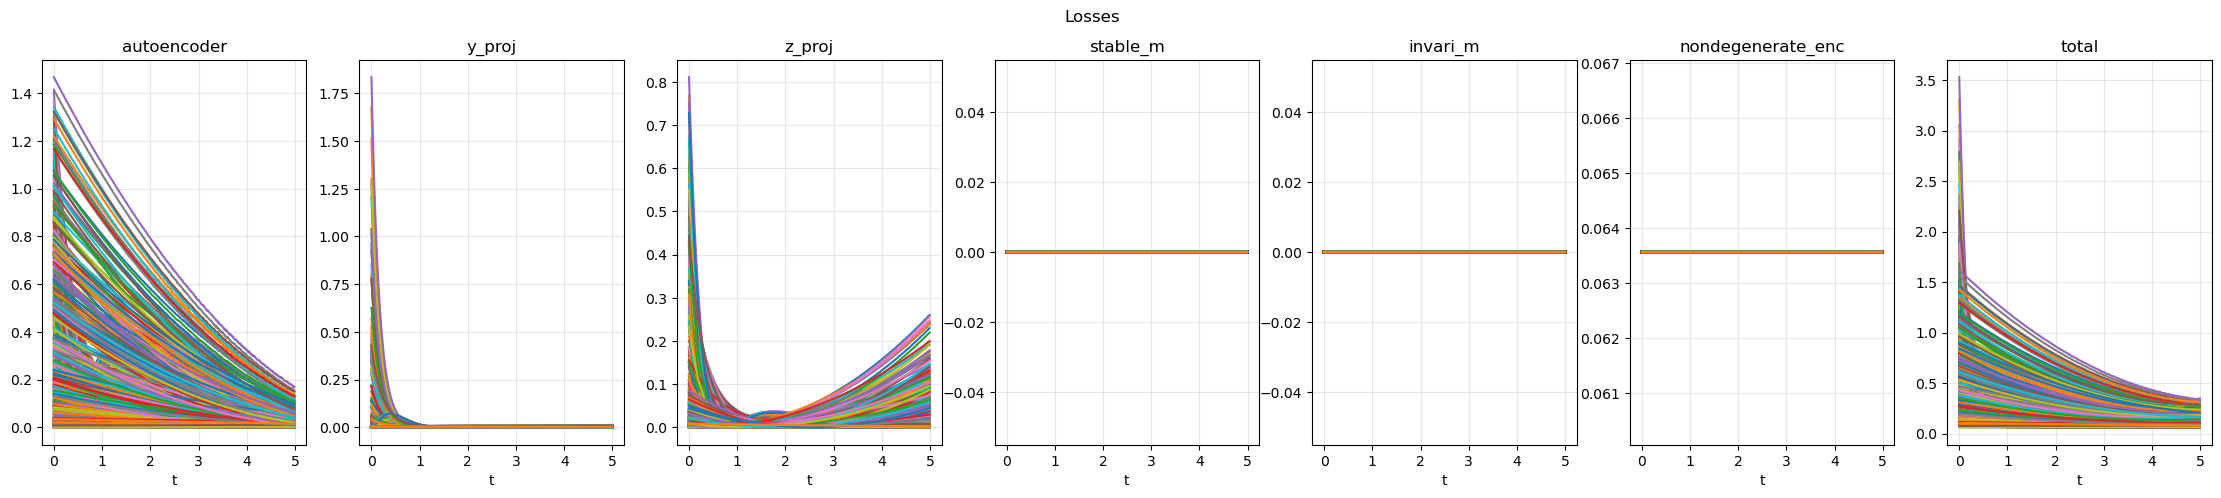

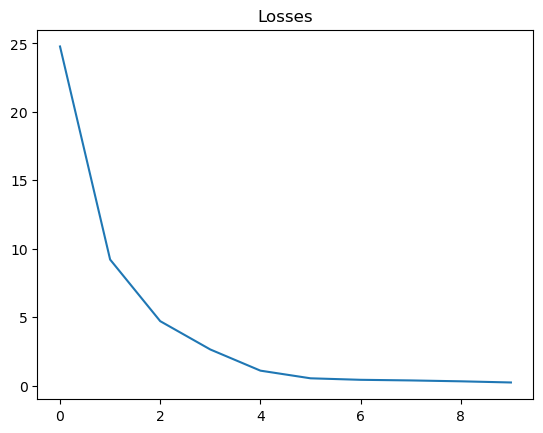

100%|██████████| 10/10 [00:21<00:00,  2.11s/it, loss=4.41e-05, lr=5.00e-02]



Params after training:
{'nn_decoder': {'bias': None,
                'kernel': Array([[-0.5942152 , -0.742549  ],
       [-1.0127019 , -0.01504134]], dtype=float32)},
 'nn_encoder': {'bias': None,
                'kernel': Array([[-0.05322288, -0.7349299 ],
       [-1.048618  ,  0.05794544]], dtype=float32)},
 'nn_fy': {'bias': None, 'kernel': Array([[0.059526]], dtype=float32)},
 'nn_fz': {'bias': None, 'kernel': Array([[0.8316196 ],
       [0.03430938]], dtype=float32)},
 'nn_gy': {'bias': Array([-1.0433475], dtype=float32), 'kernel': Array([[0.00364982]], dtype=float32)},
 'nn_psi': {'bias': None, 'kernel': Array([[1.2520461]], dtype=float32)}}


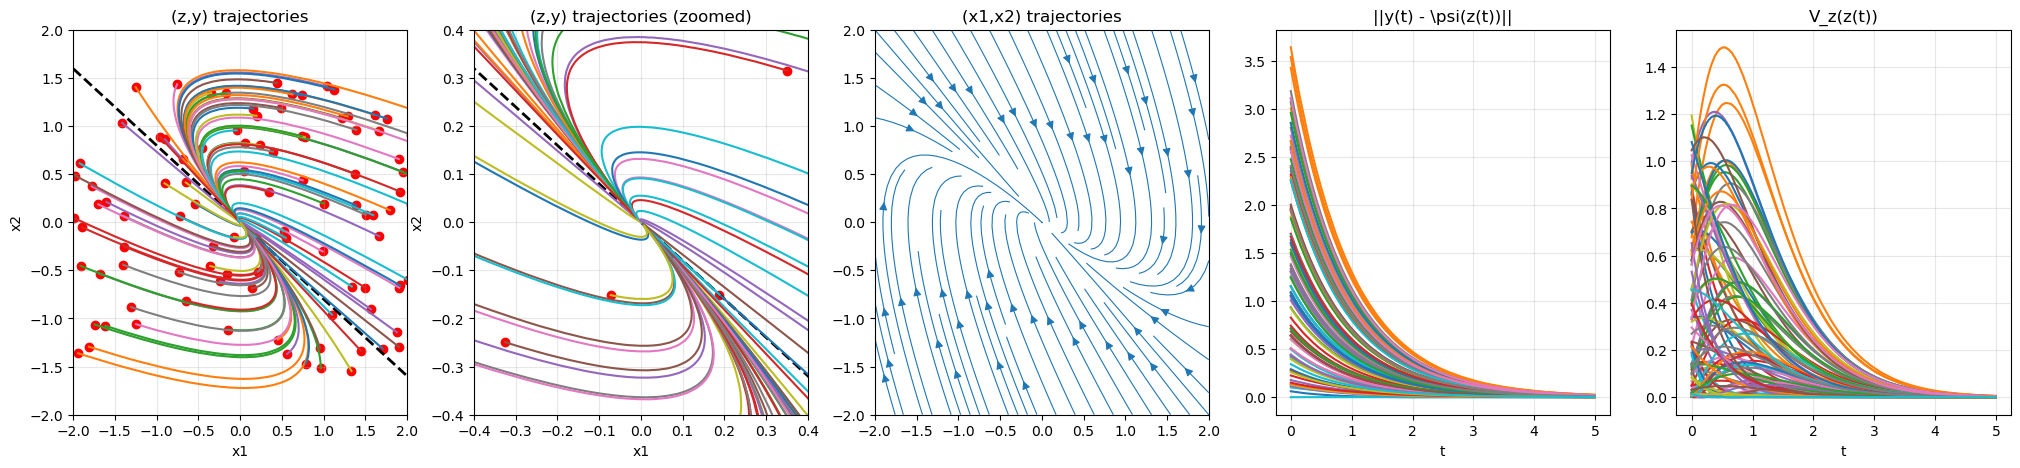

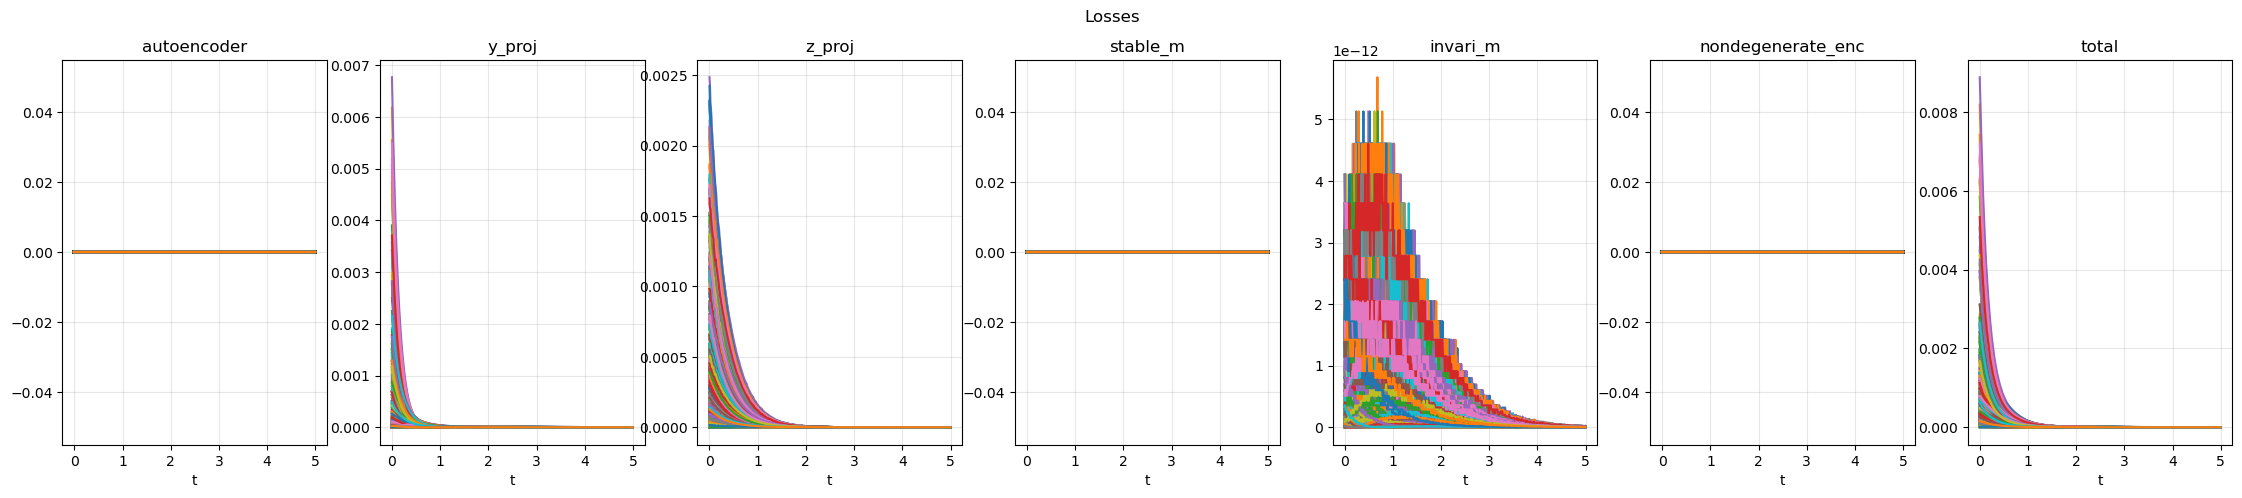

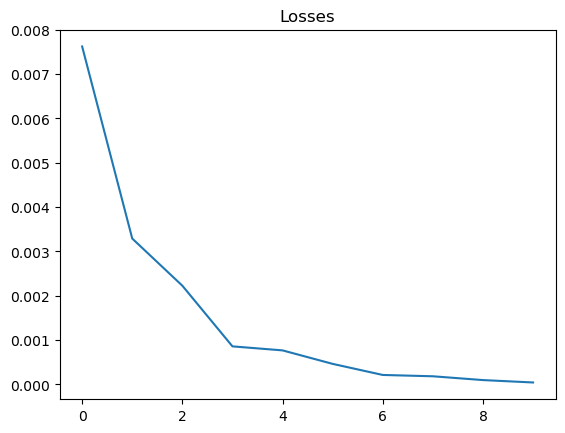

In [1]:

%load_ext autoreload
%autoreload 2


import jax
from pprint import pprint
from functools import partial

import sys, ipynbname
from os.path import dirname
sys.path.append(dirname(dirname(ipynbname.path())))
from train import *
from rom import *


cfg_rollout = CfgRollout()
cfg_rom = CfgDIROM()
cfg_train = CfgTrain()
cfg_data = CfgData()

ts = jnp.arange(cfg_rollout.t0, cfg_rollout.t1 + cfg_rollout.dt, cfg_rollout.dt)
rng = jax.random.PRNGKey(42)
rom_nn = NNDoubleIntegratorROM(cfg_rom=cfg_rom)
rom_expert = DoubleIntegratorROM(cfg_rom=cfg_rom)


print("Before training:")
pprint(rom_nn.get_nn_params(), depth=3, width=120)

integrator = Integrator(
    solver=partial(dfx.diffeqsolve, solver=dfx.Tsit5()),
    ts=ts
)


if (train_supervised:=True):
    cfg_loss_dyn = CfgLoss(autoencoder=1.0, 
                           y_proj=1.0, z_proj=1.0,
                           stable_m=1.0, invari_m=0.0,
                           nondegenerate_enc=1.0, supervised=True)
    train(rom_nn, rom_expert, integrator, cfg_train, cfg_data, cfg_loss_dyn, rng)

if (train_zd_policy_only:=True):
    cfg_loss_zd = CfgLoss(autoencoder=0.0, 
                          y_proj=1.0, z_proj=1.0, 
                          stable_m=1.0, invari_m=1.0,
                          nondegenerate_enc=0.0, supervised=False)
    train(rom_nn, rom_expert, integrator, cfg_train, cfg_data, cfg_loss_zd, rng)

In [2]:
nn_params =  rom_nn.get_nn_params()
E = nn_params["nn_encoder"]["kernel"]
D = nn_params["nn_decoder"]["kernel"]
print(jnp.linalg.det(E), E @ E.T)
# print(E, D, E@D, D@E)


-0.7737447 [[0.5429546  0.01322462]
 [0.01322462 1.1029572 ]]
